In [1]:
import pandas as pd
import cptac
import numpy as np
import requests
import json
import deva
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
import lifelines
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test
%matplotlib inline

In [2]:
ov = cptac.Ovarian()
clinical = ov.get_clinical()
proteomics = ov.get_proteomics()

In [3]:
follow_up = pd.read_excel('../Follow_Up_Data/Ovary_One_Year_Clinical_Data_20160927.xls')

In [4]:
for col in follow_up.columns:
    if len(follow_up[col].value_counts()) <= 1:
        follow_up = follow_up.drop(col, axis=1)

cols_to_drop = ['Short Title', 'Event', 'Modified Time',
                'Modified By', 'Status', 'CRF Name', 
                'Was a Review of the Initial Pathological Findings Done?', 
                'Was the Pathology Review consistent with the Diagnosis?', 
                'Adjuvant (Post-Operative) Radiation Therapy', 
                'Adjuvant (Post-Operative) Immunotherapy', 
                'Adjuvant (Post-Operative) Hormone Therapy', 
                'Anatomic Site of New Tumor Event', 
                'Other Site of New Tumor Event or Lymph Node Location', 
                'Method Of Diagnosis of New Tumor Event', 
                'Date of Additional Surgery for New Tumor Event', 
                'Additional Hormone Therapy Treatment of New Tumor Event', 
                'Additional Targeted Molecular Therapy Treatment of New Tumor Event', 
                'What Type of Malignancy was This?', 'Primary Site of Disease', 
                'Laterality of the Disease', 'Did the patient have surgery for this malignancy?',
                'Number of Days from Date of Initial Pathologic Diagnosis of the Tumor Submitted for CPTAC to the Date of Initial Diagnosis of Other Malignancy', 
                'Did the patient receive pharmaceutical therapy for this malignancy?', 
                'Was the patient staged using FIGO?', ' Was the patient staged using AJCC?']

follow_up = follow_up.drop(cols_to_drop, axis=1).copy()

In [5]:
#Replace variations of NaN with one consistent value
things_to_replace = ['Not Reported/ Unknown', 'Reported/ Unknown', 
                     'Not Applicable', 'na', 'unknown', 'Not Performed', 
                     'Unknown tumor status', 'Unknown']

follow_up = follow_up.replace(things_to_replace, np.nan)

chemo_to_replace = ['Chemotherapy', 'Chemo', 'chemotherapy']
phase_to_replace = ['Phase I', 'Phase 1', 'Pahse I', 'With other Phase I drug']
inhibitors_to_replace = ['PARP Inhibitor', 'aromatase inhibitor']
other_to_replace = ['alkylating agent', 'plant alkaloid', 
                    'monoclonal antibody', 'GOG9923']

col = 'Clinical Trial Drug Classification'

follow_up[col] = follow_up[col].replace(chemo_to_replace, 'Chemotherapy')
follow_up[col] = follow_up[col].replace(phase_to_replace, 'Phase I')
follow_up[col] = follow_up[col].replace(inhibitors_to_replace, 'Inhibitors')
follow_up[col] = follow_up[col].replace(other_to_replace, 'Other')

In [6]:
follow_up = follow_up.rename({'PPID': 'Patient_ID'}, axis='columns')

In [7]:
patient_data = pd.merge(clinical, follow_up, on = 'Patient_ID')

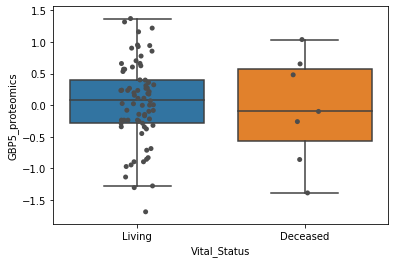

In [8]:
#Sam's Code
omics_genes=["GBP2", "GBP5", "RAC2"]
df = ov.join_metadata_to_omics(metadata_df_name="clinical", 
                                       omics_df_name="proteomics", 
                                       metadata_cols="Vital_Status",
                                       omics_genes=["GBP2", "GBP5", "RAC2"])

df1 = ov.reduce_multiindex(df, levels_to_drop="Database_ID")

clinical_attribute = "Vital_Status"
data_col = "GBP5_proteomics"
sns.boxplot(x="Vital_Status", y=data_col, data=df1, showfliers=False)
sns.stripplot(x="Vital_Status", y=data_col, data=df1, color='0.3')
plt.show()

In [65]:
df_clean = df1.dropna(axis=0, how='any')
living = df_clean[df_clean["Vital_Status"] == 'Living']
dead = df_clean[df_clean["Vital_Status"] == 'Deceased']
#living
for gene in omics_genes:
    print(gene)
    gene += "_proteomics"
    print(scipy.stats.ttest_ind(living[gene], dead[gene]), '\n')

GBP2
Ttest_indResult(statistic=0.9376885702119404, pvalue=0.3512624078297031) 

GBP5
Ttest_indResult(statistic=0.4142003164633323, pvalue=0.6798498748343362) 

RAC2
Ttest_indResult(statistic=1.1437298743557582, pvalue=0.2561895567872052) 



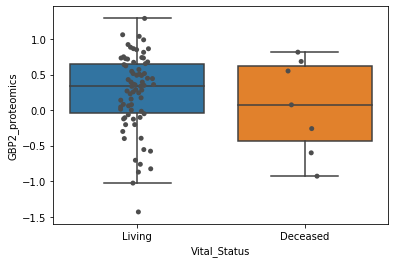

In [119]:
#Attempt to join some stuff that may or may not be wise to join, but we're going for it.
omics_genes=["GBP2", "GBP5", "RAC2"]
df = ov.join_metadata_to_omics(metadata_df_name="clinical", 
                                       omics_df_name="proteomics", 
                                       metadata_cols=["Vital_Status",
                                                      'Days_Between_Collection_And_Last_Contact', 
                                                      'Days_Between_Collection_And_Death'],
                                       omics_genes=["GBP2", "GBP5", "RAC2"])

df1 = ov.reduce_multiindex(df, levels_to_drop="Database_ID")

clinical_attribute = "Vital_Status"
data_col = "GBP2_proteomics"
sns.boxplot(x="Vital_Status", y=data_col, data=df1, showfliers=False)
sns.stripplot(x="Vital_Status", y=data_col, data=df1, color='0.3')
plt.show()

In [170]:
df_genes = df1.copy()
omics_cols = ['GBP2_proteomics', 'GBP5_proteomics', 'RAC2_proteomics']

for col in omics_cols:
    lower_25_filter = df_genes[col] <= df_genes[col].quantile(.25)
    upper_25_filter = df_genes[col] >= df_genes[col].quantile(.75)

    df_genes[col] = np.where(lower_25_filter, "Lower_25%", df_genes[col])
    df_genes[col] = np.where(upper_25_filter, "Upper_25%", df_genes[col])
    df_genes[col] = np.where(~lower_25_filter & ~upper_25_filter, "Middle_50%", df_genes[col])
    
df_genes['Vital_Status'] = df_genes['Vital_Status'].replace('Living', False)
df_genes['Vital_Status'] = df_genes['Vital_Status'].replace('Deceased', True)

## StackOverflow Saving Grace: 
https://stackoverflow.com/questions/46563833/how-to-merge-combine-columns-in-pandas

In [171]:
cols = ['Days_Between_Collection_And_Last_Contact', 'Days_Between_Collection_And_Death']

df_genes = df_genes.assign(Days_Until_Last_Contact_Or_Death=df_genes[cols].sum(1)).drop(cols, 1)

In [172]:
df_genes_clean = df_genes.copy().dropna()

In [173]:
df_genes_clean['Vital_Status'] = df_genes_clean['Vital_Status'].astype(bool)

In [174]:
#T-tests to compare gene expression levels between living and deceased
omics_genes = ['GBP2', 'GBP5', 'RAC2']
living = df_genes[df_genes["Vital_Status"] == 'Living']
dead = df_genes[df_genes["Vital_Status"] == 'Deceased']
for gene in omics_genes:
    print(gene)
    gene += "_proteomics"
    print(scipy.stats.ttest_ind(living[gene], dead[gene]), '\n')

GBP2
Ttest_indResult(statistic=nan, pvalue=nan) 

GBP5
Ttest_indResult(statistic=nan, pvalue=nan) 

RAC2
Ttest_indResult(statistic=nan, pvalue=nan) 



C:\Users\Daniel\AppData\Local\conda\conda\envs\Research\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


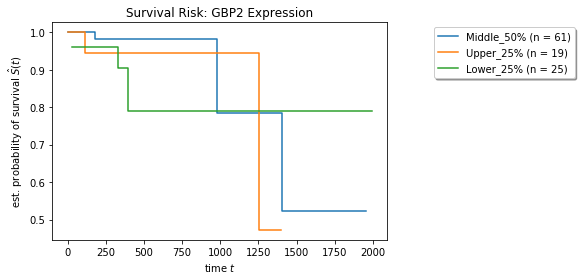

In [175]:
for value in df_genes_clean['GBP2_proteomics'].unique():
    mask = df_genes_clean['GBP2_proteomics'] == value
    time_cell, survival_prob_cell = kaplan_meier_estimator(df_genes_clean["Vital_Status"][mask],
                                                           df_genes_clean["Days_Until_Last_Contact_Or_Death"][mask])
    plt.step(time_cell, survival_prob_cell, where="post",
             label="%s (n = %d)" % (value, mask.sum()))

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
ax = plt.subplot(111)
ax.legend(loc='upper center', bbox_to_anchor=(1.35, 1), shadow=True, ncol=1)
plt.title('Survival Risk: GBP2 Expression')
plt.show()

C:\Users\Daniel\AppData\Local\conda\conda\envs\Research\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


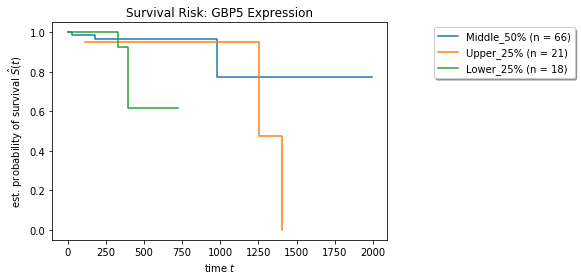

In [176]:
for value in df_genes_clean['GBP5_proteomics'].unique():
    mask = df_genes_clean['GBP5_proteomics'] == value
    time_cell, survival_prob_cell = kaplan_meier_estimator(df_genes_clean["Vital_Status"][mask],
                                                           df_genes_clean["Days_Until_Last_Contact_Or_Death"][mask])
    plt.step(time_cell, survival_prob_cell, where="post",
             label="%s (n = %d)" % (value, mask.sum()))

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
ax = plt.subplot(111)
ax.legend(loc='upper center', bbox_to_anchor=(1.35, 1), shadow=True, ncol=1)
plt.title('Survival Risk: GBP5 Expression')
plt.show()

C:\Users\Daniel\AppData\Local\conda\conda\envs\Research\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


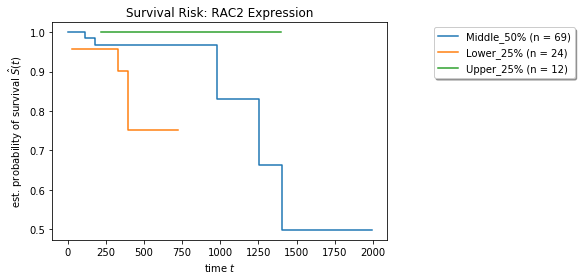

In [177]:
for value in df_genes_clean['RAC2_proteomics'].unique():
    mask = df_genes_clean['RAC2_proteomics'] == value
    time_cell, survival_prob_cell = kaplan_meier_estimator(df_genes_clean["Vital_Status"][mask],
                                                           df_genes_clean["Days_Until_Last_Contact_Or_Death"][mask])
    plt.step(time_cell, survival_prob_cell, where="post",
             label="%s (n = %d)" % (value, mask.sum()))

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
ax = plt.subplot(111)
ax.legend(loc='upper center', bbox_to_anchor=(1.35, 1), shadow=True, ncol=1)
plt.title('Survival Risk: RAC2 Expression')
plt.show()